### Importation de librairies

In [1]:
#Importation de librairies
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importation de fichiers contenant des fonctions
import dataSource as ds
import dataVisualization as dv

### Lecture du fichier

In [2]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

In [3]:
#1.
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#2.
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Affichage du dataframe
df

,Device,Trip,Time,GpsTime,GpsWeek,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,NumberOfSats,Differential,FixMode,Pdop,GpsBytes,UtcTime,UtcWeek
120957,10204,268,72571,506824400,1708,239.485600,7.54,42.285965,-83.733940,212.93100,12,1,4,1.32,4,506808400,1708
120958,10204,268,72591,506824600,1708,239.828290,7.49,42.285957,-83.733955,212.98801,13,1,4,1.30,4,506808600,1708
120959,10204,268,72612,506824800,1708,239.733800,7.42,42.285954,-83.733971,213.04300,13,1,4,1.30,4,506808800,1708
120960,10204,268,72633,506825000,1708,239.743190,7.42,42.285946,-83.733986,213.08299,13,1,4,1.30,10,506809000,1708
120961,10204,268,72652,506825200,1708,239.775100,7.38,42.285938,-83.734001,213.12100,13,1,4,1.30,4,506809200,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,17101,28,1595811,492287200,1710,60.193279,11.00,42.285923,-83.733826,212.14600,11,1,4,1.58,4,492271200,1710
997736,17101,28,1595830,492287400,1710,60.422611,10.99,42.285934,-83.733803,212.07300,11,1,4,1.58,4,492271400,1710
997737,17101,28,1595851,492287600,1710,60.365929,10.98,42.285942,-83.733780,211.98599,11,1,4,1.58,4,492271600,1710
997738,17101,28,1595870,492287800,1710,60.441559,10.90,42.285954,-83.733749,211.89700,11,1,4,1.58,4,492271800,1710


## Modèles

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dataSource import *
from sklearn.metrics import mean_squared_error
#fichier contenant des classes pour transformer et evaluer les données
import Eval
from model_physique1 import *

#### Paramètres pour la contruction des jeux de données

In [5]:
#on prend un point sur 'step' du jeu de données
freq_train = 200
freq_test = freq_train

train_size = 0.8

#features
attrs_x = [['Latitude','Longitude','GpsHeading', 'GpsSpeed'], ['Trip','Latitude','Longitude','GpsTime']]

#targets
labels = ['Latitude','Longitude']

#modèles
#models = [LinearRegression(), physic_model(freq)]
models = [LinearRegression(), model_physique1(freq_test)]

#preprocessing
#preprocessor = [MinMaxScaler() for _ in range(len(models))]
preprocessor = None

#### Création des données d'apprentissage et de test et évaluation des modèles

In [6]:
#création des données d'apprentissage et de test pour la prédiction du prochain point (à partir de toutes nos données)
traitement = Eval.Traitement(df, attrs_x, labels, freq_train, freq_test, preprocessor)
traitement.set_data_train_test(train_size)

#Apprentissage des modèles et évaluation à partir de l'objet traitement
evaluateur = Eval.Evaluation(models,traitement)
evaluateur.fit()

#Affichage des résultats
#evaluateur.afficher_resultats()

In [7]:
models[0].predict(traitement.l_Xtest[0]).shape

(13750, 2)

In [8]:
models[0].predict(traitement.l_Xtest[0])

array([[ 42.28596326, -83.7340597 ],
       [ 42.28595522, -83.73408262],
       [ 42.28594818, -83.73410558],
       ...,
       [ 42.28005728, -83.73364561],
       [ 42.2800343 , -83.73364555],
       [ 42.28000833, -83.73364546]])

#### Tableau d'erreurs en fonction de la fréquence

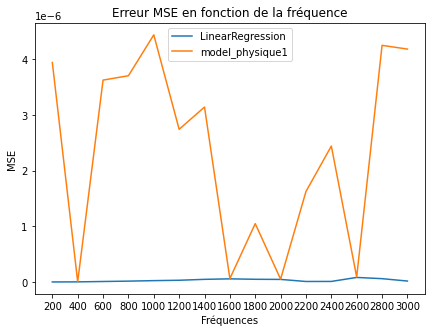

array([[3.76936841e-09, 3.93689088e-06],
       [5.07803804e-09, 6.81156716e-09],
       [1.18893303e-08, 3.62218599e-06],
       [1.83175035e-08, 3.70043058e-06],
       [2.73165634e-08, 4.43324683e-06],
       [3.40193493e-08, 2.74019269e-06],
       [5.03719296e-08, 3.13922960e-06],
       [5.93165571e-08, 6.36856598e-08],
       [5.14911356e-08, 1.04900640e-06],
       [4.91451918e-08, 5.35314916e-08],
       [1.20058885e-08, 1.62511947e-06],
       [1.29285080e-08, 2.43948194e-06],
       [8.45160911e-08, 9.17648963e-08],
       [6.27012246e-08, 4.24523372e-06],
       [1.97454039e-08, 4.17827803e-06]])

In [9]:
nb_freq = 15
freq_train = [200*i for i in range(1,nb_freq+1)]
freq_test = freq_train

evaluateur.tabMSEFreq(freq_train)

#### Matrice erreurs MSE pour chaque case

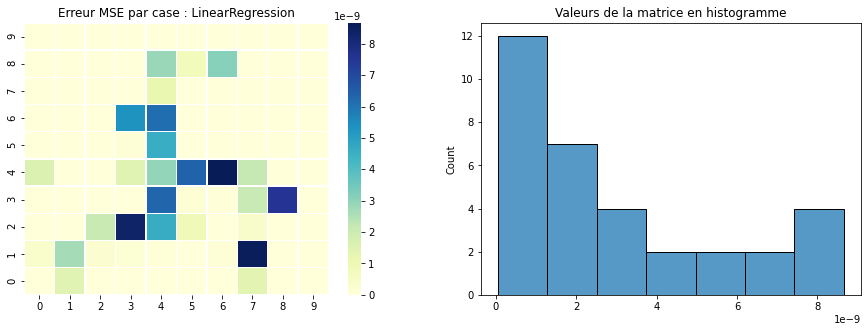

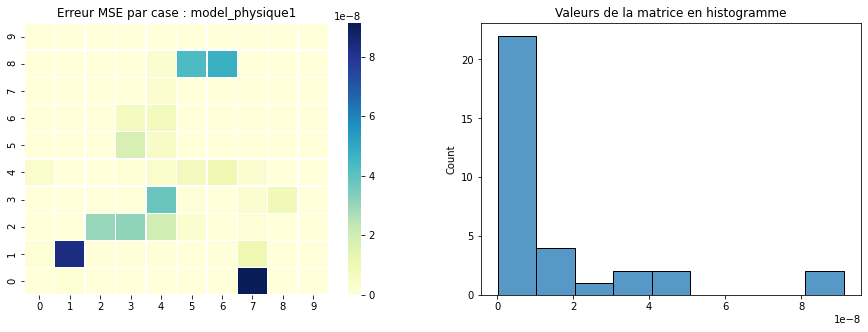

In [10]:
#bins / nombre d'intervalles
n_interval = 10

#récupération de paramètres
latitude_min, latitude_max, longitude_min, longitude_max, ecart_x, ecart_y = ds.calcul_param(df)
min_datapoints = 20

#fréquences
freq_train = 400
freq_test = freq_train

#On apprend sur toutes les données puis on prédit et calcule l'erreur MSE sur chaque case
evaluateur.matMSECase(freq_train,freq_test,latitude_min,longitude_min,ecart_x,ecart_y,min_datapoints,train_size,n_interval)